# N Body Simulator
### Miles lucas

This is a simulator for n-bodies given a gravitational potential field. It operates by concurrently calculating the acceleration on each point due to each other point using the equation

$$
m_i \mathbf{\ddot{r_i}} = m_i \sum_{j\ne i}^{N} \frac{G m_j}{|\mathbf{r_i - r_j} |^3} (\mathbf{r_i-r_j})
$$

In order to get the position $\mathbf{r_i}$ we can simply solve the differential equation using standard kinematics equation

$$
\mathbf{r} = \frac{1}{2}\mathbf{a} t^2 + \mathbf{v_0} t + \mathbf{r_0}
$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

plt.style.use('seaborn')

Let's set up our system using numpy arrays as our basis for easier calculations

In [13]:
N = 10

r = np.random.randn(N, 3) * 50 - 25 # three coordinate system
v = np.random.rand(N, 3) * 4 - 2
# v = np.zeros((N,3))
# m = np.ones(N) # uniform mass
m = np.random.rand(N) * 10

G = 1 # keep it simple

Now let's define some functions we can use for getting the acceleration and also for changing the position

In [4]:
from numba import jit
from numba.types import *

def accelerate(r, v, a, time_step=1):
    """
    Applies force on every single particle in system
    """
    v += a * time_step
    r += 0.5 * v * time_step 
    return r, v
    
# @jit('f8[:](f8[:], f8[:,:], f8[:,:])')
def get_acceleration(ri, other_r, other_m):
    """
    Finds the acceleration for each particle given 
    """
    return sum([-G * mj * (ri - rj) / np.linalg.norm(ri - rj)**3 for rj, mj in zip(other_r, other_m)])

Let's just take a look at our system before applying anything

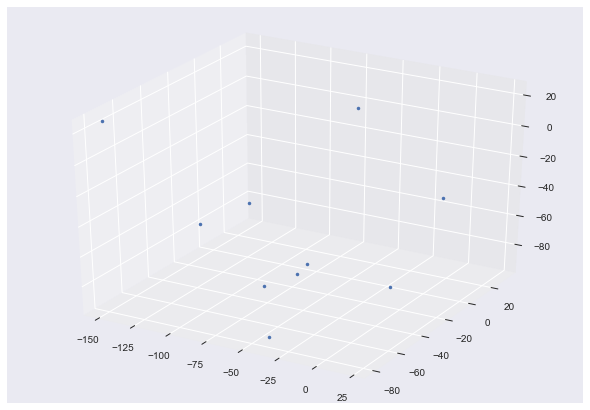

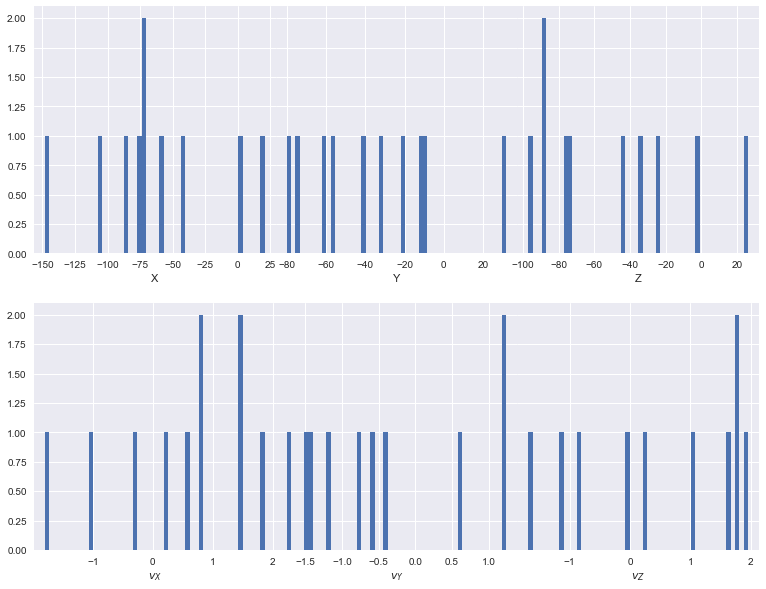

In [5]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')

ax.plot(r[:,0], r[:,1], r[:,2], '.');

fig, ax = plt.subplots(2, 3, sharey='row', figsize=(13, 10), squeeze=True)
fig.subplots_adjust(wspace=0)

labels = [['X', 'Y', 'Z'], ['$v_X$', '$v_Y$', '$v_Z$']]
for i in range(3):
    ax[0, i].hist(r[:,i], 50)
    ax[0, i].set_xlabel(labels[0][i])
    ax[1, i].hist(v[:,i], 50)
    ax[1, i].set_xlabel(labels[1][i])

Now let's set up our animation code. The way matplotlib handles animation is by basically creating empty containers for the data, which are then encoded each animation frame with our data. This means we handle animation in two steps:
1. Getting the numerical data for every single frame
2. Actually creating the animation

In [17]:
frame_data = np.zeros((500, N, 3))
v_data = np.zeros((500, N, 3))
for t in range(len(frame_data)):
    a = np.zeros((N, 3))
    frame_data[t] = r
    v_data[t] = v
    a = [get_acceleration(ri, np.delete(r, i), np.delete(m, i)) 
     for i, ri in enumerate(r)]
    accelerate(r, v, a)
  

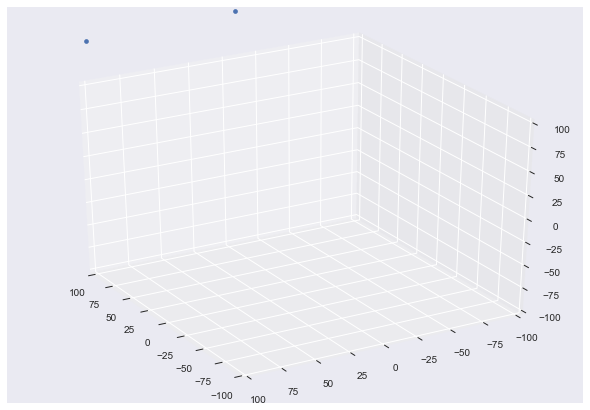

In [18]:
#Set up plot
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
lims = (-100, 100)
ax.set_xlim(*lims)
ax.set_ylim(*lims)
ax.set_zlim(*lims)

# Set up empty points for each particle
pts = sum([ax.plot([], [], [], 'C0.', ms=3*np.sqrt(b)) for b in m], [])

def init():
    """
    This function is called as part of the animation function 
    and serves to empty out the canvas each iteration
    """
    for pt in pts:
        pt.set_data([], [])
        pt.set_3d_properties([])
    return pts

def animate(i):
    """
    This function is called at each frame and represents one 
    time step for the system
    """
    ax.view_init(30, .3 * i) # fun little rotation
    
    for r, pt in zip(frame_data[i], pts):
        pt.set_data(r[0], r[1])
        pt.set_3d_properties(r[2])
        
    return pts

# This is the animation function from matplotlib
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=500, interval=20, blit=True);
HTML(anim.to_html5_video())

In [ ]:
fig2, ax = plt.subplots(2, 3, sharey='row', figsize=(13, 10))
fig.subplots_adjust(wspace=0)

labels = [['X', 'Y', 'Z'], ['$v_X$', '$v_Y$', '$v_Z$']]

def animate_hists(t):
    rt = frame_data[t]
    vt = v_data[t]
    plt.cla()
    for i in range(3):
        ax[0, i].hist(rt[:,i], 50)
        ax[0, i].set_xlabel(labels[0][i])
        
        ax[1, i].hist(vt[:,i], 50)
        ax[1, i].set_xlabel(labels[1][i])
        
    return 

# This is the animation function from matplotlib
anim2 = animation.FuncAnimation(fig2, animate_hists, 
                               frames=500, interval=20, blit=True)
HTML(anim2.to_html5_video())